# OSMnx features demo

Author: [Geoff Boeing](https://geoffboeing.com/)

Get street networks and other spatial data anywhere in the world from OpenStreetMap then analyze and visualize them.

More info:

  - [Overview of OSMnx](http://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [Documentation and install instructions](https://osmnx.readthedocs.io)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)
  - [Journal article and citation info](http://geoffboeing.com/publications/osmnx-complex-street-networks/)
  - [GitHub repo](https://github.com/gboeing/osmnx)
  
This notebook provides a quick tour of some of OSMnx's key features including how to:

  - download/model street networks
  - calculate stats
  - visualize centrality
  - impute speeds/travel times and calculate shortest paths
  - attach and visualize elevation data and edge grades
  - download/model other infrastructure types
  - download points of interest data

In [1]:
import networkx as nx
import osmnx as ox

ox.__version__

'1.8.0'

## Working with street networks

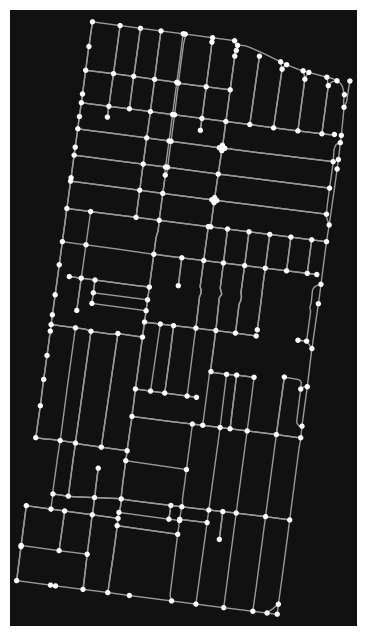

In [2]:
# download/model a street network for some city then visualize it
G = ox.graph_from_place("Collingwood, Melbourne, Australia", network_type="drive")
fig, ax = ox.plot_graph(G)

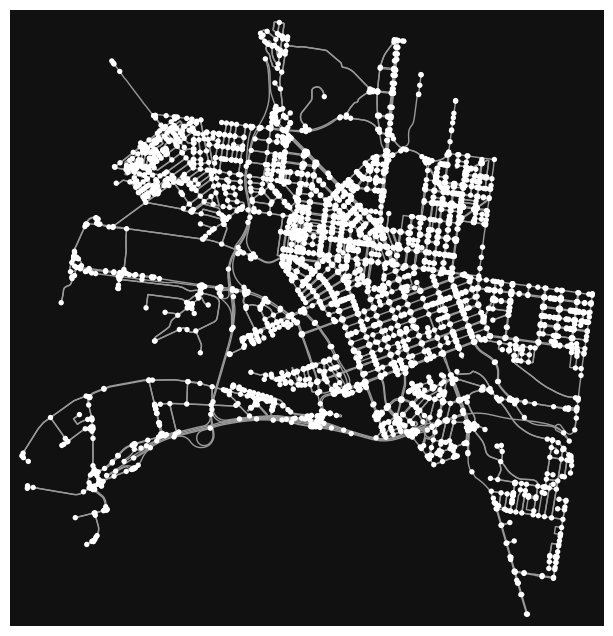

In [3]:
# download/model a street network for some city then visualize it
G = ox.graph_from_place("City of Melbourne, Victoria, Australia", network_type="drive")
fig, ax = ox.plot_graph(G)

OSMnx geocodes the query "Piedmont, California, USA" to retrieve the place boundaries of that city from the Nominatim API, retrieves the drivable street network data within those boundaries from the Overpass API, constructs a graph model, then simplifies/corrects its topology such that nodes represent intersections and dead-ends and edges represent the street segments linking them. All of this is discussed in detail in the documentation and these examples.

OSMnx models all networks as NetworkX `MultiDiGraph` objects. You can convert to:
  - undirected MultiGraphs
  - DiGraphs without (possible) parallel edges
  - GeoPandas node/edge GeoDataFrames

In [4]:
# convert your MultiDiGraph to an undirected MultiGraph
M = ox.utils_graph.get_undirected(G)

# convert your MultiDiGraph to a DiGraph without parallel edges
D = ox.utils_graph.get_digraph(G)

In [5]:
# you can convert your graph to node and edge GeoPandas GeoDataFrames
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_nodes.head()

,y,x,street_count,highway,ref,geometry
osmid,,,,,,
21578145,-37.825690,144.937782,3,NaN,NaN,POINT (144.93778 -37.82569)
26034526,-37.814398,144.954709,4,NaN,NaN,POINT (144.95471 -37.81440)
26034533,-37.813953,144.960317,4,traffic_signals,NaN,POINT (144.96032 -37.81395)
26034534,-37.814661,144.957857,4,traffic_signals,NaN,POINT (144.95786 -37.81466)
26034544,-37.816641,144.958721,4,NaN,NaN,POINT (144.95872 -37.81664)


In [6]:
gdf_edges.head()

osmid  oneway  \
u        v          key                                                         
21578145 683094366  0    [484854832, 28119418, 1083073387, 775968519]    True   
26034526 259616706  0                                       581959662    True   
         6207096572 0                                       581959665    True   
26034533 2020813831 0                                      1201027245    True   
         6804266286 0                                      1126800685    True   

                          lanes  ref                  name        highway  \
u        v          key                                                     
21578145 683094366  0    [3, 4]   M1     West Gate Freeway       motorway   
26034526 259616706  0         2  NaN       Lonsdale Street       tertiary   
         6207096572 0         3  A60           King Street          trunk   
26034533 2020813831 0       NaN  NaN  Little Bourke Street  living_street   
         6804266286 0       NaN  NaN          Queen Street       tertiary   

                        maxspeed reversed    length  \
u        v          key                               
21578145 683094366  0         80    False  1827.578   
26034526 259616706  0         40    False    13.146   
         6207096572 0         40    False    44.059   
26034533 2020813831 0         20    False    13.743   
         6804266286 0         40    False    87.148   

                                                                  geometry  \
u        v          key                                                      
21578145 683094366  0    LINESTRING (144.93778 -37.82569, 144.93717 -37...   
26034526 259616706  0    LINESTRING (144.95471 -37.81440, 144.95478 -37...   
         6207096572 0    LINESTRING (144.95471 -37.81440, 144.95468 -37...   
26034533 2020813831 0    LINESTRING (144.96032 -37.81395, 144.96017 -37...   
         6804266286 0    LINESTRING (144.96032 -37.81395, 144.96034 -37...   

                        bridge junction width access tunnel  
u        v          key                                      
21578145 683094366  0      NaN      NaN   NaN    NaN    NaN  
26034526 259616706  0      NaN      NaN   NaN    NaN    NaN  
         6207096572 0      NaN      NaN   NaN    NaN    NaN  
26034533 2020813831 0      NaN      NaN   NaN    NaN    NaN  
         6804266286 0      NaN      NaN   NaN    NaN    NaN

You can create a graph from node/edge GeoDataFrames, as long as gdf_nodes is indexed by osmid and gdf_edges is multi-indexed by u, v, key (following normal MultiDiGraph structure). This allows you to load graph node/edge ShapeFiles or GeoPackage layers as GeoDataFrames then convert to a MultiDiGraph for graph analytics.

In [7]:
# convert node/edge GeoPandas GeoDataFrames to a NetworkX MultiDiGraph
G2 = ox.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=G.graph)

## Basic street network stats

In [8]:
# what sized area does our network cover in square meters?
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

50173123.56983372

In [9]:
# show some basic stats about the network
ox.basic_stats(G_proj, area=graph_area_m, clean_int_tol=15)

{'n': 4039,
 'm': 7984,
 'k_avg': 3.9534538252042584,
 'edge_length_total': 590807.035,
 'edge_length_avg': 73.99887712925852,
 'streets_per_node_avg': 3.200297103243377,
 'streets_per_node_counts': {0: 0,
  1: 200,
  2: 52,
  3: 2553,
  4: 1210,
  5: 21,
  6: 3},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.04951720722951226,
  2: 0.012874473879673186,
  3: 0.632087150284724,
  4: 0.2995791037385491,
  5: 0.005199306759098787,
  6: 0.0007427581084426838},
 'intersection_count': 3839,
 'street_length_total': 466936.047,
 'street_segment_count': 6385,
 'street_length_avg': 73.13015614722005,
 'circuity_avg': 1.0330407066421397,
 'self_loop_proportion': 0.0006264682850430697,
 'clean_intersection_count': 1628,
 'node_density_km': 80.50126666677025,
 'intersection_density_km': 76.51506876299356,
 'edge_density_km': 11775.368822267608,
 'street_density_km': 9306.49745874587,
 'clean_intersection_density_km': 32.44765093674226}

stats documentation: https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats

In [10]:
# save graph to disk as geopackage (for GIS) or graphml file (for gephi etc)
ox.save_graph_geopackage(G, filepath="./data/mynetwork.gpkg")
ox.save_graphml(G, filepath="./data/mynetwork.graphml")

## Visualize street centrality

Here we plot the street network and color its edges (streets) by their relative closeness centrality.

In [11]:
# convert graph to line graph so edges become nodes and vice versa
edge_centrality = nx.closeness_centrality(nx.line_graph(G))
nx.set_edge_attributes(G, edge_centrality, "edge_centrality")

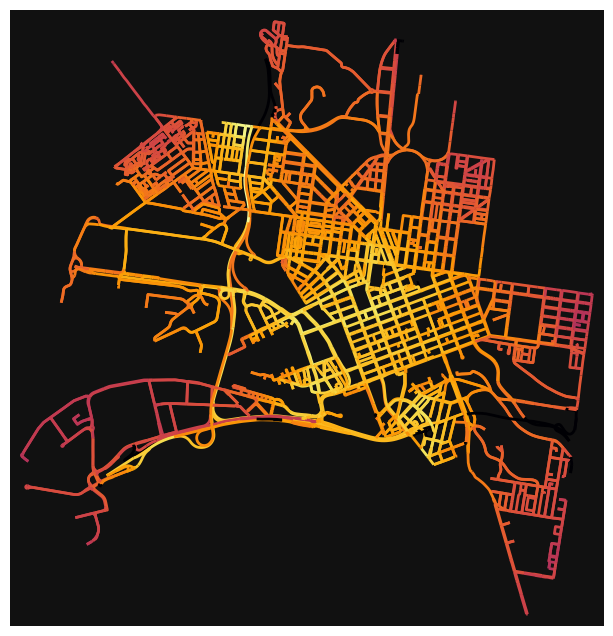

In [12]:
# color edges in original graph with closeness centralities from line graph
ec = ox.plot.get_edge_colors_by_attr(G, "edge_centrality", cmap="inferno")
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=2, node_size=0)

## Routing

In [13]:
# impute missing edge speeds and calculate edge travel times with the speed module
G = ox.speed.add_edge_speeds(G)
G = ox.speed.add_edge_travel_times(G)

In [14]:
# get the nearest network nodes to two lat/lng points with the distance module
# orig = ox.distance.nearest_nodes(G, X=-122.245846, Y=37.828903)
# dest = ox.distance.nearest_nodes(G, X=-122.215006, Y=37.812303)
orig = ox.distance.nearest_nodes(G, X=144.984848, Y=-37.796248)
dest = ox.distance.nearest_nodes(G, X=144.988774, Y=-37.808170)

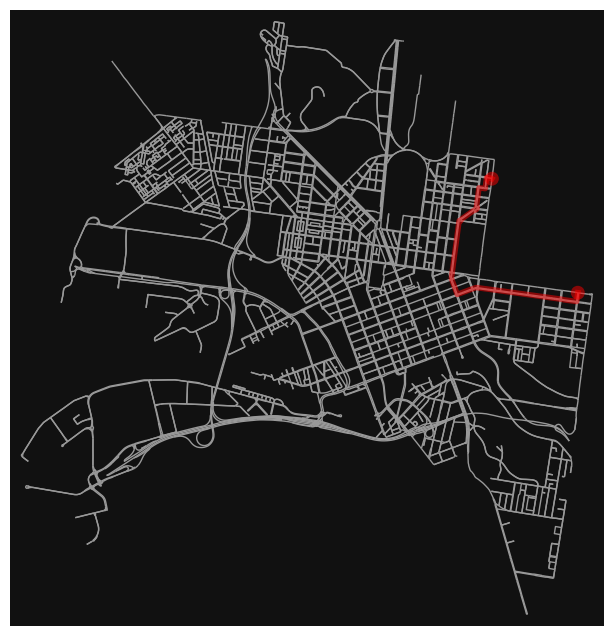

In [15]:
# find the shortest path between nodes, minimizing travel time, then plot it
route = ox.shortest_path(G, orig, dest, weight="travel_time")
fig, ax = ox.plot_graph_route(G, route, node_size=0)

In [16]:
# how long is our route in meters?
edge_lengths = ox.utils_graph.route_to_gdf(G, route)["length"]
round(sum(edge_lengths))

3812

In [17]:
# how far is it between these two nodes as the crow flies?
# use OSMnx's vectorized great-circle distance (haversine) function
orig_x = G.nodes[orig]["x"]
orig_y = G.nodes[orig]["y"]
dest_x = G.nodes[dest]["x"]
dest_y = G.nodes[dest]["y"]
round(ox.distance.great_circle(orig_y, orig_x, dest_y, dest_x))

1996

You can add elevation attributes to your graph's nodes automatically with the `elevation` module, using either local raster files or the Google Maps Elevation API.

In [18]:
# add elevation to nodes automatically, calculate edge grades, plot network
# you need a google elevation api key to run this cell!
try:
    from keys import google_elevation_api_key

    G = ox.elevation.add_node_elevations_google(G, api_key=google_elevation_api_key)
    G = ox.elevation.add_edge_grades(G)
    nc = ox.plot.get_node_colors_by_attr(G, "elevation", cmap="plasma")
    fig, ax = ox.plot_graph(G, node_color=nc, node_size=20, edge_linewidth=2, edge_color="#333")
except ImportError:
    print("You need a google_elevation_api_key to run this cell.")

You need a google_elevation_api_key to run this cell.


Nodes are colored from lowest elevation (dark blue) to highest (bright yellow).

Example: create [elevation-based](12-node-elevations-edge-grades.ipynb) impedance functions to route around hills.

## Get networks other ways

make queries less ambiguous to help the geocoder out, if it's not finding what you're looking for

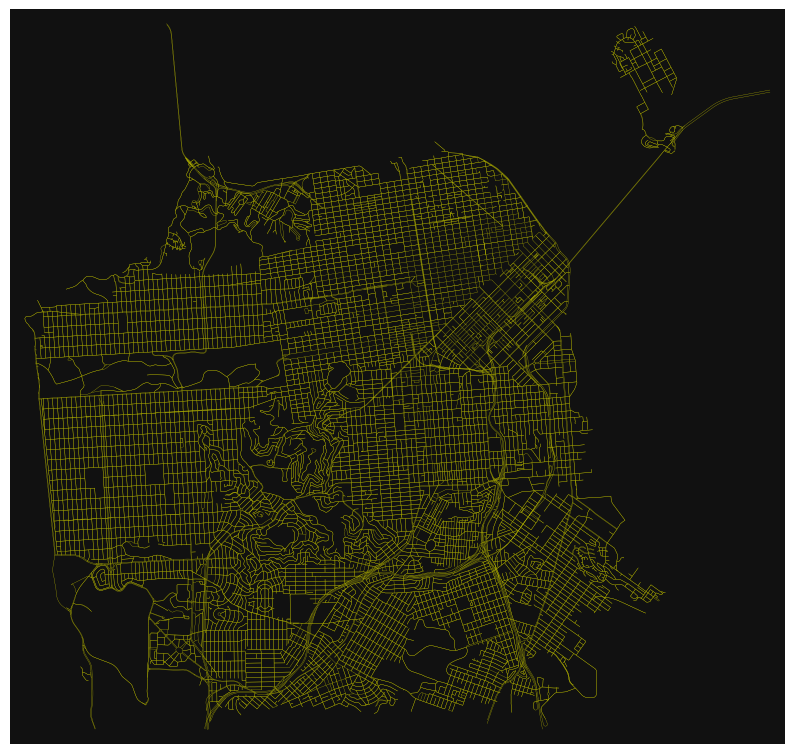

In [19]:
# you can make query an unambiguous dict to help the geocoder find it
place = {"city": "San Francisco", "state": "California", "country": "USA"}
G = ox.graph_from_place(place, network_type="drive", truncate_by_edge=True)
fig, ax = ox.plot_graph(G, figsize=(10, 10), node_size=0, edge_color="y", edge_linewidth=0.2)

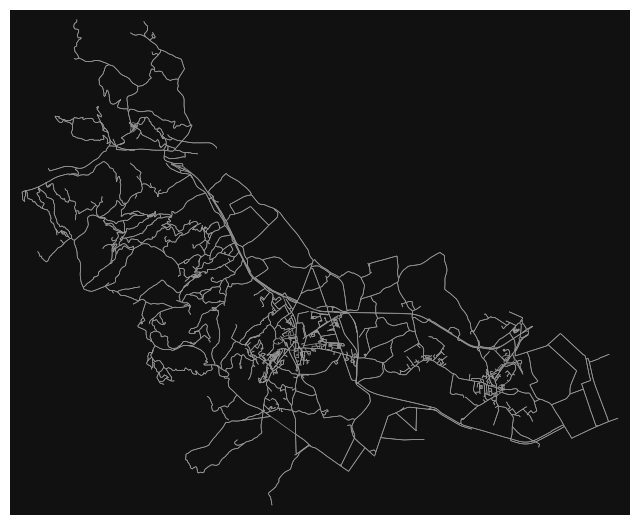

In [20]:
# you can get networks anywhere in the world
G = ox.graph_from_place("Sinalunga, Italy", network_type="all")
fig, ax = ox.plot_graph(G, node_size=0, edge_linewidth=0.5)

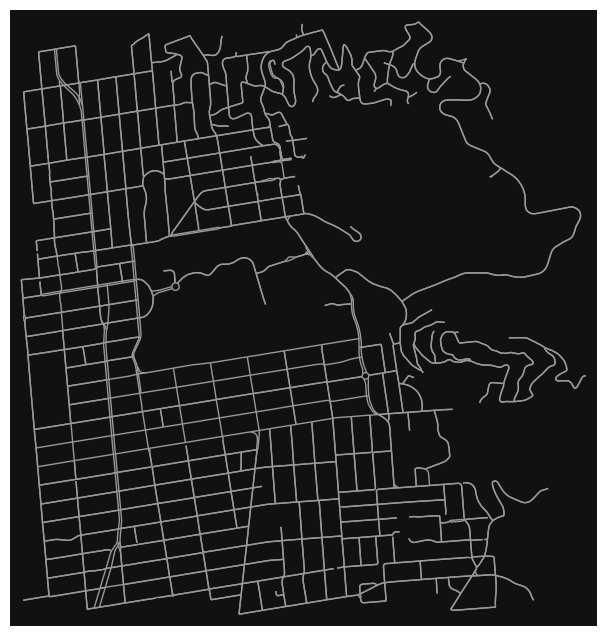

In [21]:
# or get network by address, coordinates, bounding box, or any custom polygon
# ...useful when OSM just doesn't already have a polygon for the place you want
wurster_hall = (37.870605, -122.254830)
one_mile = 1609  # meters
G = ox.graph_from_point(wurster_hall, dist=one_mile, network_type="drive")
fig, ax = ox.plot_graph(G, node_size=0)

Examples of [getting networks](01-overview-osmnx.ipynb) by coordinates, bounding box, or any custom polygon shape.

## Get other networked infrastructure types

...like rail or electric grids or even the canals of Venice and Amsterdam, using the `custom_filter` parameter: [see more examples](08-custom-filters-infrastructure.ipynb).

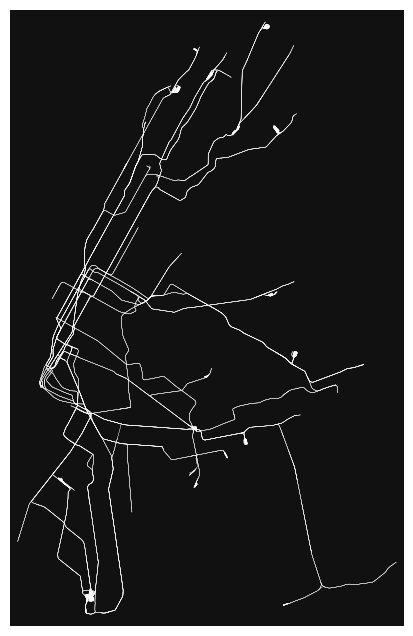

In [22]:
# get NY subway rail network
G = ox.graph_from_place(
    "New York, New York, USA",
    retain_all=False,
    truncate_by_edge=True,
    simplify=True,
    custom_filter='["railway"~"subway"]',
)

fig, ax = ox.plot_graph(G, node_size=0, edge_color="w", edge_linewidth=0.2)

## Get any geospatial features' geometries and attributes

Use the `features` module to download any OSM features, such as local amenities, points of interest, or building footprints, and turn them into a GeoDataFrame: [see docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.features). For more usage examples of downloading geospatial features from OSM, see [this notebook](16-download-osm-geospatial-features.ipynb).

In [23]:
# get all building footprints in some neighborhood
place = "SoHo, New York, NY"
tags = {"building": True}
gdf = ox.features_from_place(place, tags)
gdf.shape

(849, 87)

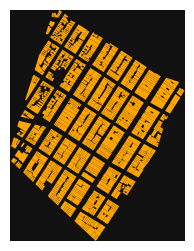

In [24]:
fig, ax = ox.plot_footprints(gdf, figsize=(3, 3))

See the other notebooks for more examples of visualization with OSMnx.

In [25]:
# get all parks and bus stops in some neighborhood
tags = {"leisure": "park", "highway": "bus_stop"}
gdf = ox.features_from_place(place, tags)
gdf.shape

(21, 36)